# Reanalysis of Dispersion Measure Periodicity for Fast Radio Bursts and Perytons

# A Blog post and Open Notebook

tl;dr:
* Analysis with FRB DMs as of November 2015 shows that whatever small significance for periodicity in the DM distribution has totally disappeared.
* This notebook is available as a "binder" that can be run with modifications (or new FRBs!) at http://mybinder.org/repo/caseyjlaw/FRB-dm-periodicity.

The study of Fast Radio Bursts (FRBs) was stirred by an article on the arxiv by Hippke et al (http://arxiv.org/pdf/1503.05245v2.pdf). This article performed a meta-analysis of the Dispersion Measures (DMs; the frequency-dependent time of arrival of the impulse) and arrival times of published FRBs. That analysis had flaws, as I described in an earlier post and in a Dinah review I posted (http://dinah-peer-review.appspot.com).

However, the knee-jerk reaction against the Hippke et al analysis was unfair to some degree as there was a modest (~5%) chance that there was a periodicity in the measured DMs. Also, disconcertingly, that underlying period was similar to that revealed by a similar analysis on the apparent DM of Perytons, a related, but decidedly non-astrophysical phenomenon (http://labs.adsabs.harvard.edu/adsabs/abs/2015MNRAS.451.3933P).

Here, we perform the DM periodicity analysis again with the latest and greatest sample of measured DMs. For bonus fun, we built and tested this notebook as a "binder", a tool for reproducible science.

Primary motivating questions:
* Is there a significant "periodicity" in the dispersion measures of FRBs?
* Are there shared properties (particularly dispersion measure) between Perytons and FRBs?




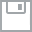
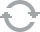
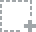
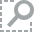
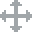
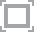
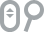
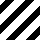
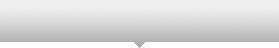
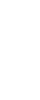
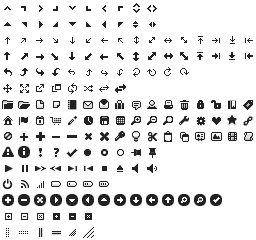
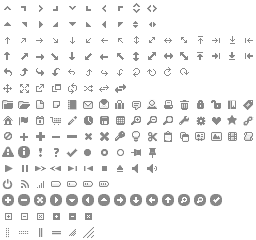
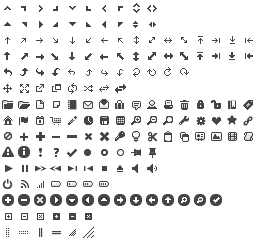
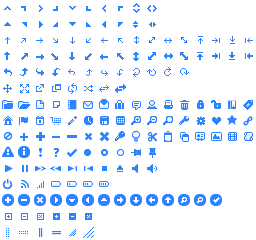
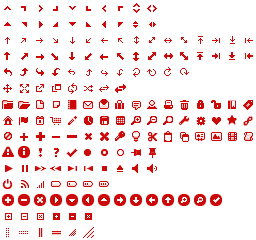
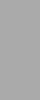
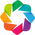
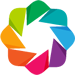

In [1]:
import numpy as n
import os, glob
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, gridplot
from bokeh.charts.utils import cycle_colors
output_notebook()

## Define and Generate Dispersion Measure distributions

* DMfrb is all known FRBs (starting with Hippke et al. sample)
* FRB detection papers included: Lorimer, Thornton, Spitler, Petroff, Keane & Stappers, Ravi, Burke-Spolaor & Bannister, Champion, Masui (GBT detection; not yet published)
* DMper is observed Perytons
* dmr1 is random with max of 1000 pc/cm3
* dmr2 is random with mean/std equal to that of observed FRBs

In [2]:
dmfrb = n.array([  375. ,   553.3,   557.4,   562.7,   723. ,   746. ,   788. ,     790. ,   944.4,  1103.6, 899.6, 1629.2, 952.4, 469.9, 861, 623.3])  # FRB DMs
dmper = n.array([344, 400, 382, 217, 213, 396, 421, 357, 393, 374, 278, 402, 400, 350, 350, 350, 375])      # Peryton DMs

# random values
dmmax = max(dmfrb.max(), dmper.max())
dmr1 = n.random.rand(1000)*dmmax
dmr2 = n.random.normal(dmfrb.mean(), dmfrb.std(), 1000)

In [3]:
print len(dmfrb), len(dmper), len(dmr1), len(dmr2)

16 17 1000 1000


## Define useful functions for calculating random DM distributions and their cumulative distribution properties

### Here we use a Rayleigh test (in "inttrial" function) to calculate significance of "periodicity" or integer multiples

In [4]:
TOOLS = 'pan, wheel_zoom'
WIDTH = 600
def cdist(dmlist, returnplot=False, h=400, w=WIDTH, tools=TOOLS, label=True, legendlist=[]):
    """ Plot cumulative distribution
    dmlist is list of dm arrays.
    """
    
    assert len(dmlist[0]), 'Need data to plot.'
    
    p = figure(plot_width=w, plot_height=h, tools=tools)
    if label:
        p.xaxis.axis_label = 'DM (pc/cm3)'
        p.xaxis.axis_label = 'Cumulative fraction'

    colors = cycle_colors(dmlist)
    for i in range(len(dmlist)):
        dms = dmlist[i]
        count = len(dms)
        cfrac = n.arange(1,count+1)/float(count)
        dms.sort()
        try:
            legend = legendlist[i]
        except IndexError:
            legend=''
        p.scatter(dms, cfrac, legend=legend, line_color=colors[i], fill_color=None)
    if not returnplot:
        show(p)
    else:
        return p
        
def inttrial(dms, dmmin=0, dmmax=0):
    """ For a given sample of DMs, find residual for a set of assumed fundamental integer DM basis
    """

    modulo = lambda dm: (n.mod(dms, dm)/dm).mean()
    ray = lambda dm: n.sqrt(n.sin(2*n.pi*dms/dm).mean()**2 + n.cos(2*n.pi*dms/dm).mean()**2)
    ray2 = lambda dm: 1./len(dms) * ( (n.sin(2*n.pi*dms/dm).sum())**2 + (n.cos(2*n.pi*dms/dm).sum())**2 )  # includes scaling with number of events

    if dmmin == 0:
        dmmin = dms.max()/float(len(dms))
    if dmmax == 0:
        dmmax = dms.max()/2
    stat = []
    grid = n.arange(dmmin,dmmax,0.5)
    for dm in grid:
#        stat.append(modulo(dm, dms))  # alternate statistic
        stat.append(ray(dm))
    return n.array(grid), n.array(stat)

def plottrial(triallist, legendlist=[]):
    """
    """
    
    assert len(triallist[0]) == 2, 'Need at least one pair of dms/stat.'
    colors = cycle_colors(triallist)

    p = figure(plot_width=WIDTH, plot_height=400, tools=TOOLS)
    p.xaxis.axis_label = 'Assumed Fundamental DM (pc/cm3)'
    p.yaxis.axis_label = 'Statistic'
    for i in range(len(triallist)):
        (grid,resid) = triallist[i]
        try:
            legend = legendlist[i]
        except IndexError:
            legend=''

        p.scatter(grid, resid, legend=legend, line_color=colors[i], fill_color=None)
    show(p)
    
def sample(dms, ntrials, size=10, thresh=0, dmmin=0, dmmax=0):
    """ Sample dms ntrials times with size values and calculate inttrial distribution.
    Minimum of inttrial distribution saved.
    """

    minresid = []
    dmresid = []
    lowesttrial = []; lowestdms = []
    for i in range(ntrials):
        sampleints = n.random.random_integers(0, len(dms)-1, size)
        dmsample = dms.take(sampleints)
        grid, resid = inttrial(dmsample, dmmin=dmmin, dmmax=dmmax)
#        minresid.append(resid.min())
#        dmresid.append(grid[n.where(resid == resid.min())])
#        if (thresh > 0) and (resid.min() < thresh):
        minresid.append(resid.max())
        dmresid.append(grid[n.where(resid == resid.max())])
        if (thresh > 0) and (resid.max() > thresh):
            lowesttrial.append((grid, resid))
            lowestdms.append(dmsample)
    if thresh > 0:
        print 'Found %d out of %d. Occurrence rate of %.3f beyond threshold Rayleigh test statistic value.' % (len(lowesttrial), ntrials, len(lowesttrial)/float(ntrials))
    return n.array(dmresid).flatten(), n.array(minresid), lowesttrial, lowestdms

## Visualize observed and simulated DM cumulative distributions

In [5]:
# cumulative distributions of all four full samples
cdist([dmfrb, dmper, dmr1, dmr2], legendlist=['DMfrb', 'DMper', 'DMr1', 'DMr2'])

## What is the value of the Rayleigh test statistic for each of the distributions above in their entirety?

In [6]:
# fundamental DM trials analysis for all four full samples
plottrial([inttrial(dmfrb), inttrial(dmper), inttrial(dmr1), inttrial(dmr2)], legendlist=['DMfrb', 'DMper', 'DMr1', 'DMr2'])

## Using published FRB DM distribution, calculate Rayleigh test statistic

In [7]:
grid, resid = inttrial(dmfrb)
thresh = resid.max()
dmpeak = grid[n.where(resid == thresh)]
print 'FRBs Rayleigh test value:', thresh, dmpeak[0]
grid, resid = inttrial(dmper)
print 'Perytons Rayleigh test value:', resid.max(), grid[n.where(resid == resid.max())][0]

FRBs Rayleigh test value: 0.46635404939 178.325
Perytons Rayleigh test value: 0.615273887653 184.764705882


In [8]:
p = figure(plot_height=400, plot_width=WIDTH, x_range=(0,2000), y_range=(-0.5,0.5), tools=TOOLS)
#axis( (0, 1200, -1, 1) )
yval = n.random.normal(-0.25, 0.05, len(dmper))
p.circle(dmper, yval, legend='Perytons', fill_color=None)
#p.text(30, -0.75, "Perytons", verticalalignment='center', horizontalalignment='left', fontsize=20)
yval = n.random.normal(0.25, 0.05, len(dmfrb))
p.cross(dmfrb, yval, legend='FRBs')
#p.text(30, 0.75, "FRBs", verticalalignment='center', horizontalalignment='left', fontsize=20)
p.xaxis.axis_label = 'DM/DMeff'
p.yaxis.axis_label = 'Arb'
show(p)

## How often does this Rayleigh test value exceed that of sample of all known FRBs?

In [9]:
dmresid, resid, lowesttrial, lowestdms = sample(dmr1, 100, size=len(dmfrb), thresh=thresh)

Found 65 out of 100. Occurrence rate of 0.650 beyond threshold Rayleigh test statistic value.


## How common is it to have a very small residual DM, if assuming a fundamental DM?

In [10]:
p = figure(plot_height=400, plot_width=WIDTH, tools=TOOLS)
p.scatter(dmresid, resid, fill_color=None)
p.xaxis.axis_label = 'DM at minimum residual'
p.yaxis.axis_label = 'Min residual for a given trial'
show(p)

## What is the cumulative DM distribution for these simulated samples with "significant" periodicities?

In [12]:
pl = []
width = 2
for i in range(0, len(lowestdms), width):
    pl2 = []
    for j in range(width):
        try:
            pl2.append(cdist([lowestdms[i+j]], h=200, w=200, tools='', label=False, returnplot=True))
        except:
            pass
    pl.append(pl2)

# append two final plots of actual FRB and Peryton DM distributions
pl.append([cdist([dmfrb], h=200, w=200, tools='', label=False, returnplot=True), None])
pl.append([cdist([dmper], h=200, w=200, tools='', label=False, returnplot=True), None])

p = gridplot(pl)
show(p)

## Takeaway

Earlier analysis showed that Hippke et al (2015) overstated the significance of an apparent periodicity in the dispersion measure for the then-known sample of 10 FRBs. Our reanalysis, first published on the arxiv review service Dinah, showed that there was some modest significance to the periodicity, but nothing particularly unusual given that only 10 FRBs were known.

With the addition of new FRB detections, we have reanalyzed the DMs and shown that there is no sigificant periodicity in their distribution.

For posterity, we have built this analysis as an IPython (Jupyter) notebook and tested it on http://mybinder.org. Feel free to reproduce this analysis with your own modifications or the addition of new FRB detections in the future!